# Image QC

This notebooked is an example of image QC, using  the [Rohban et al.
(2017)](https://doi.org/10/ghkrp7) data. We will perform filtering of images and
show how we can additionnally filter single-cell profiles in the same way. The
overall idea is to use a kNN-based approach removes low quality images. Let's
jump right in! First, we load some packages.

In [1]:
import warnings
import numpy as np
import scmorph as sm
import scanpy as sc
import pandas as pd
from plotnine import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300  # High resolution figures

Then, we define a function to load in the data we need and use it.

In [2]:
# Function to load single-cell and image-level data
def load_data():
    with warnings.catch_warnings():  # Catch warning that is addressed by `obs_names_make_unique``
        warnings.filterwarnings("ignore", category=UserWarning)
        qcadata = sm.datasets.rohban2017_imageQC()
    qcadata.obs_names_make_unique()
    # Set plate to category for better plotting
    qcadata.obs["Image_Metadata_Plate"] = qcadata.obs["Image_Metadata_Plate"].astype(
        "category"
    )

    # Load single-cell dataset
    scadata = sm.datasets.rohban2017_minimal()

    return scadata, qcadata


# Load in data
scadata, qcadata = load_data()

What does the image-level data look like? It contains some metadata in `obs`, as
shown here:

In [3]:
qcadata.obs.sample(5, random_state=2025)

,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well
1670-4,41754,6,h18
1466-1,41755,9,g19
2110-4,41754,5,j19
3182,41757,8,o18
2306,41757,5,k17


And it has 505 features, some examples of which are shown here:

In [4]:
print("Number of image-level features:", qcadata.shape[1])
qcadata.var.index.to_frame().sample(5, random_state=2025)[0].values

Number of image-level features: 505


array(['Image_Texture_InfoMeas2_RNA_10_0',
       'Image_ImageQuality_PercentMinimal_IllumMito',
       'Image_ImageQuality_Correlation_OrigRNA_2',
       'Image_Texture_InfoMeas1_RNA_10_0', 'Image_Granularity_8_DNA'],
      dtype=object)

And on the side of the single-cell features, we have 12,352 cells and 1687
features. **Note**: this single-cell data only comprises a few of the images for
which we have loaded in image-level data. The reason for this is that
single-cell data is much bigger, and would require a big download. You may rerun
this notebook with the whole single-cell data by substituting
`sm.datasets.rohban2017_minimal` with `sm.datasets.rohban2017` at the top of
this notebook.

In [5]:
scadata.shape

(12352, 1687)

## Identifying batch effects in QC data
In this dataset in particular, image-level data is confounded by batch effects.
This is good to check but might not be the case in your dataset.

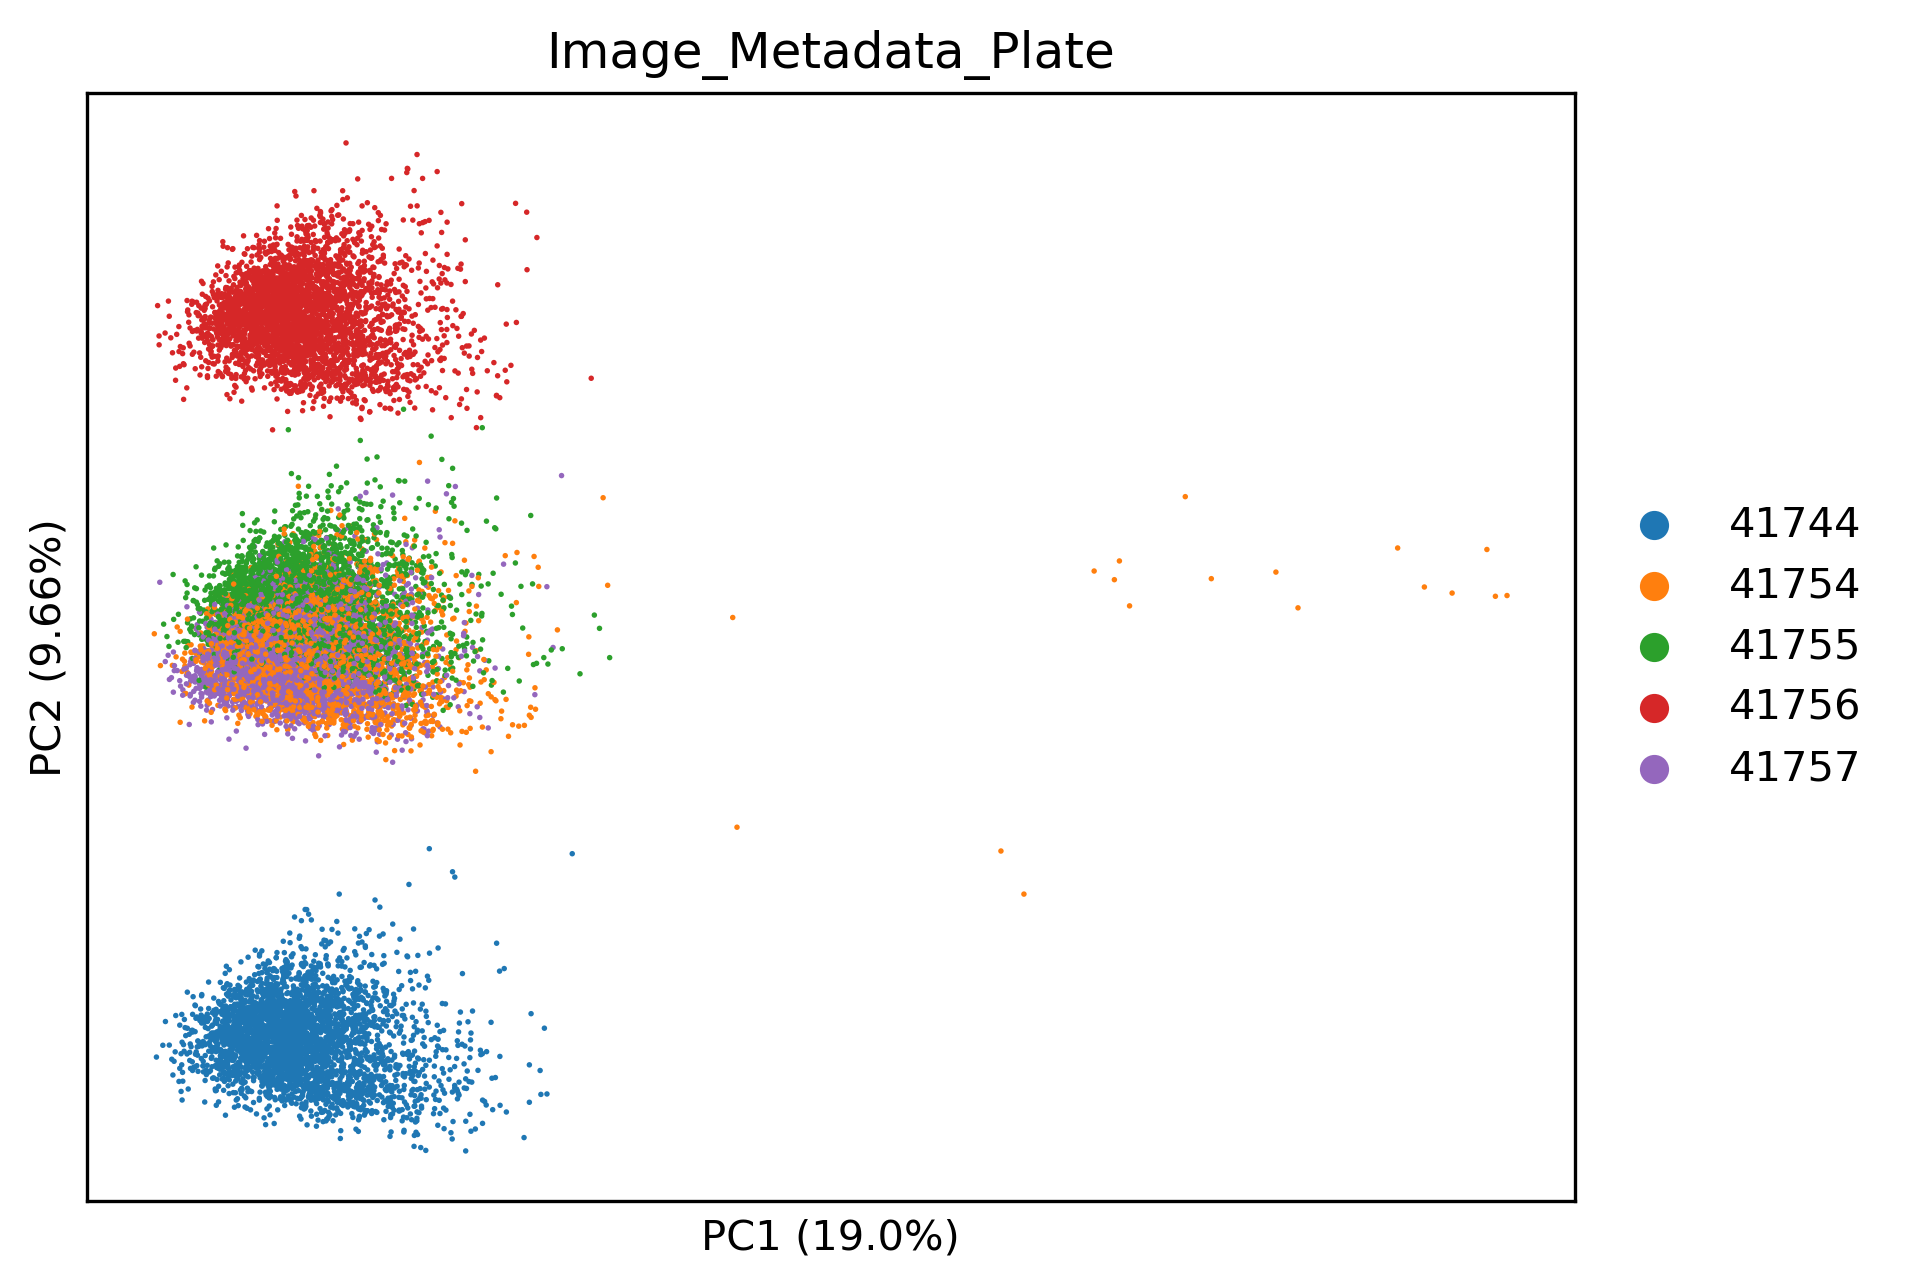

In [6]:
sm.pp.scale(qcadata)
sm.pp.pca(qcadata)
sm.pl.pca(
    sc.pp.subsample(qcadata, fraction=1, copy=True),  # For better plotting
    color="Image_Metadata_Plate",
)

## Batch correcting image QC data
Fortunately we can correct batch effects in image-level data the same way we
would correct batch effects in single-cell profiles.

In [7]:
scadata, qcadata = load_data()  # Reload raw image-level data
sm.pp.remove_batch_effects(qcadata, "Image_Metadata_Plate")  # Remove batch effects

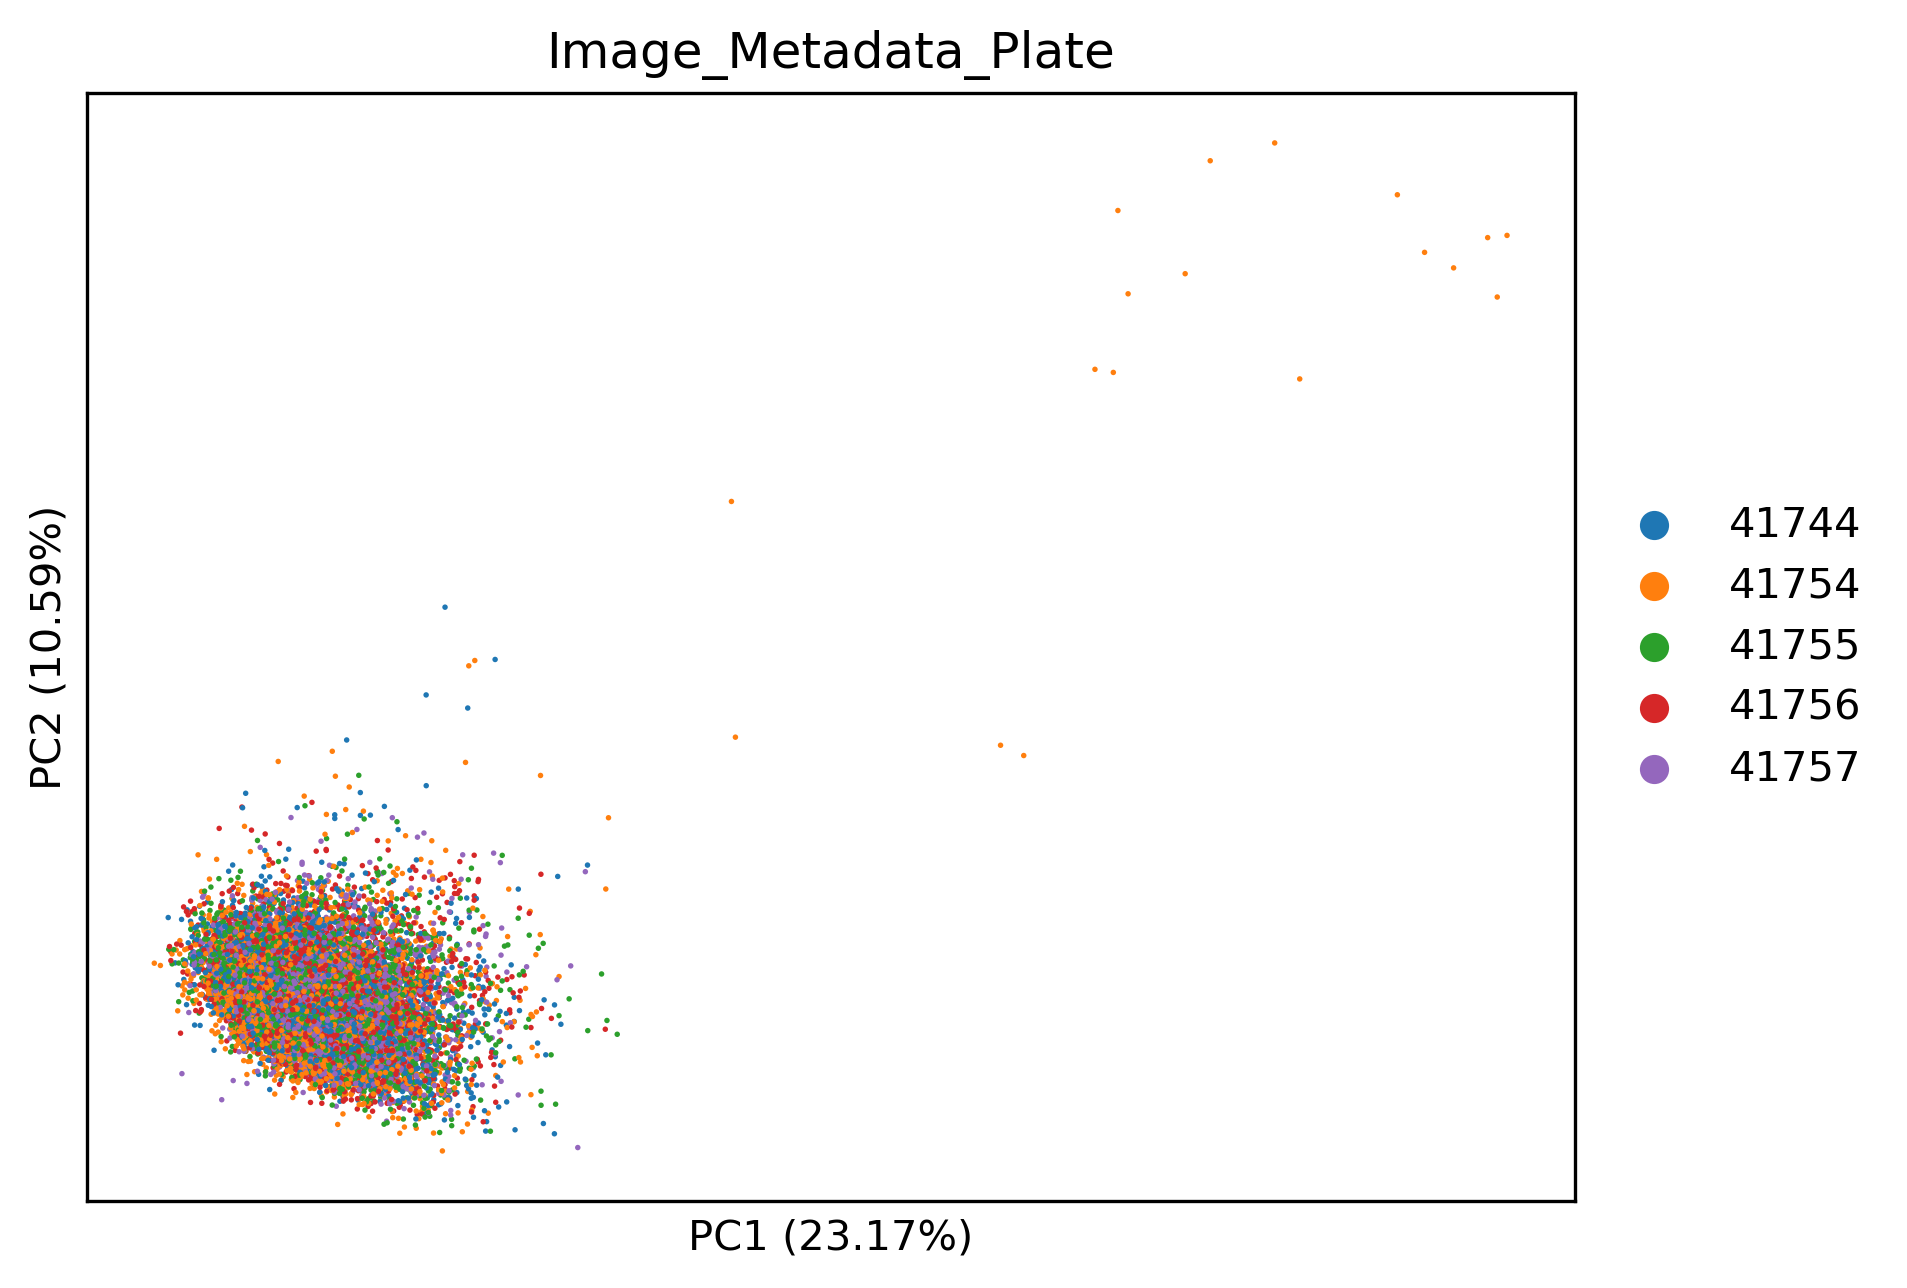

In [8]:
sm.pp.scale(qcadata)
sm.pp.pca(qcadata)
sm.pl.pca(
    sc.pp.subsample(qcadata, fraction=1, copy=True),  # For better plotting
    color="Image_Metadata_Plate",
)

## Image-level QC

We can see that now the image-level profiles are integrated well. Additionally,
some images from plate 41754 in the top right seem to be stark outliers. We can
see which ones by using:

In [9]:
# Run kNN-based QC, which detects outliers
scadata, qcadata = sm.qc.qc_images_by_dissimilarity(
    scadata, qcadata, filter=False, threshold=0.1
)

In [10]:
# Show which images were the most affected by quality issues
qcadata.obs.sort_values("ImageQCDistance", ascending=False).head(6)

,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,ImageQCDistance,PassQC
653-4,41754,6,d01,7.410741,False
656-4,41754,9,d01,7.205057,False
650-4,41754,3,d01,7.043103,False
434-4,41754,3,c01,6.651846,False
439-4,41754,8,c01,6.354570,False
435-4,41754,4,c01,6.348427,False


We can also see the distribution of kNN distances, which can inform which
threshold to set. Ideally, we are looking for a bimodal distribution of "good"
and "bad" images.

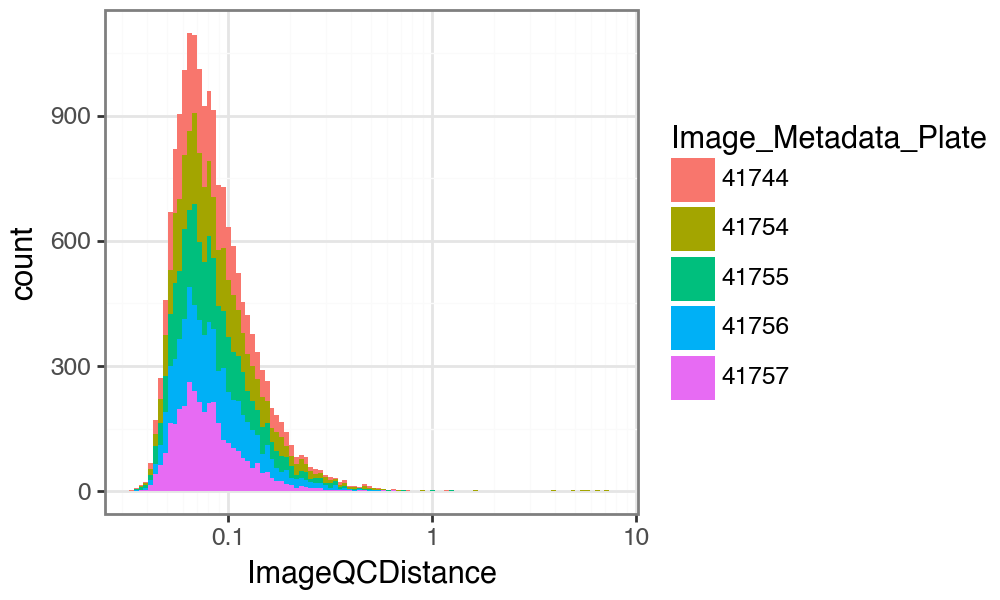

In [11]:
p = (
    ggplot(qcadata.obs, aes(x="ImageQCDistance", fill="Image_Metadata_Plate"))
    + geom_histogram(bins=100)
    + scale_x_log10()
    + theme_bw()
    + theme(figure_size=(5, 3))
)
p

This shows that in this dataset, we probably wish to set a more lenient
threshold on the image QC distance, so as not to remove too many images. Also,
while we do not see a bimodal distribution, we see a long tail of presumably
low-quality images.

**Note**: You should not perform this step blindly. Check images with large
distance (i.e. low scores) manually to confirm they are of low quality.
Otherwise you risk removing images with strong phenotypes. You should only use
this approach if you expect your image artifacts to be stronger than any
perturbation effect.

Depending on your requirements and your manual checks, you then decide on a
threshold (more on this in a later section). Here, we may for example wish to
remove images with a distance greater than 0.8.

In [ ]:
# Remove columns previously added to single-cell data during first call to
# qc_images_by_dissimilarity.
scadata.obs.drop(columns=["PassQC", "ImageQCDistance"], inplace=True)

# Run function again, now with different threshold.
scadata, qcadata = sm.qc.qc_images_by_dissimilarity(
    scadata, qcadata, filter=False, threshold=0.8
)  # filter >0.8

We can see how many images are removed by this filter:

In [13]:
qcadata.obs["PassQC"].value_counts()

PassQC
True     17238
False       35
Name: count, dtype: int64

And we can also see which ones were removed on the PCA:

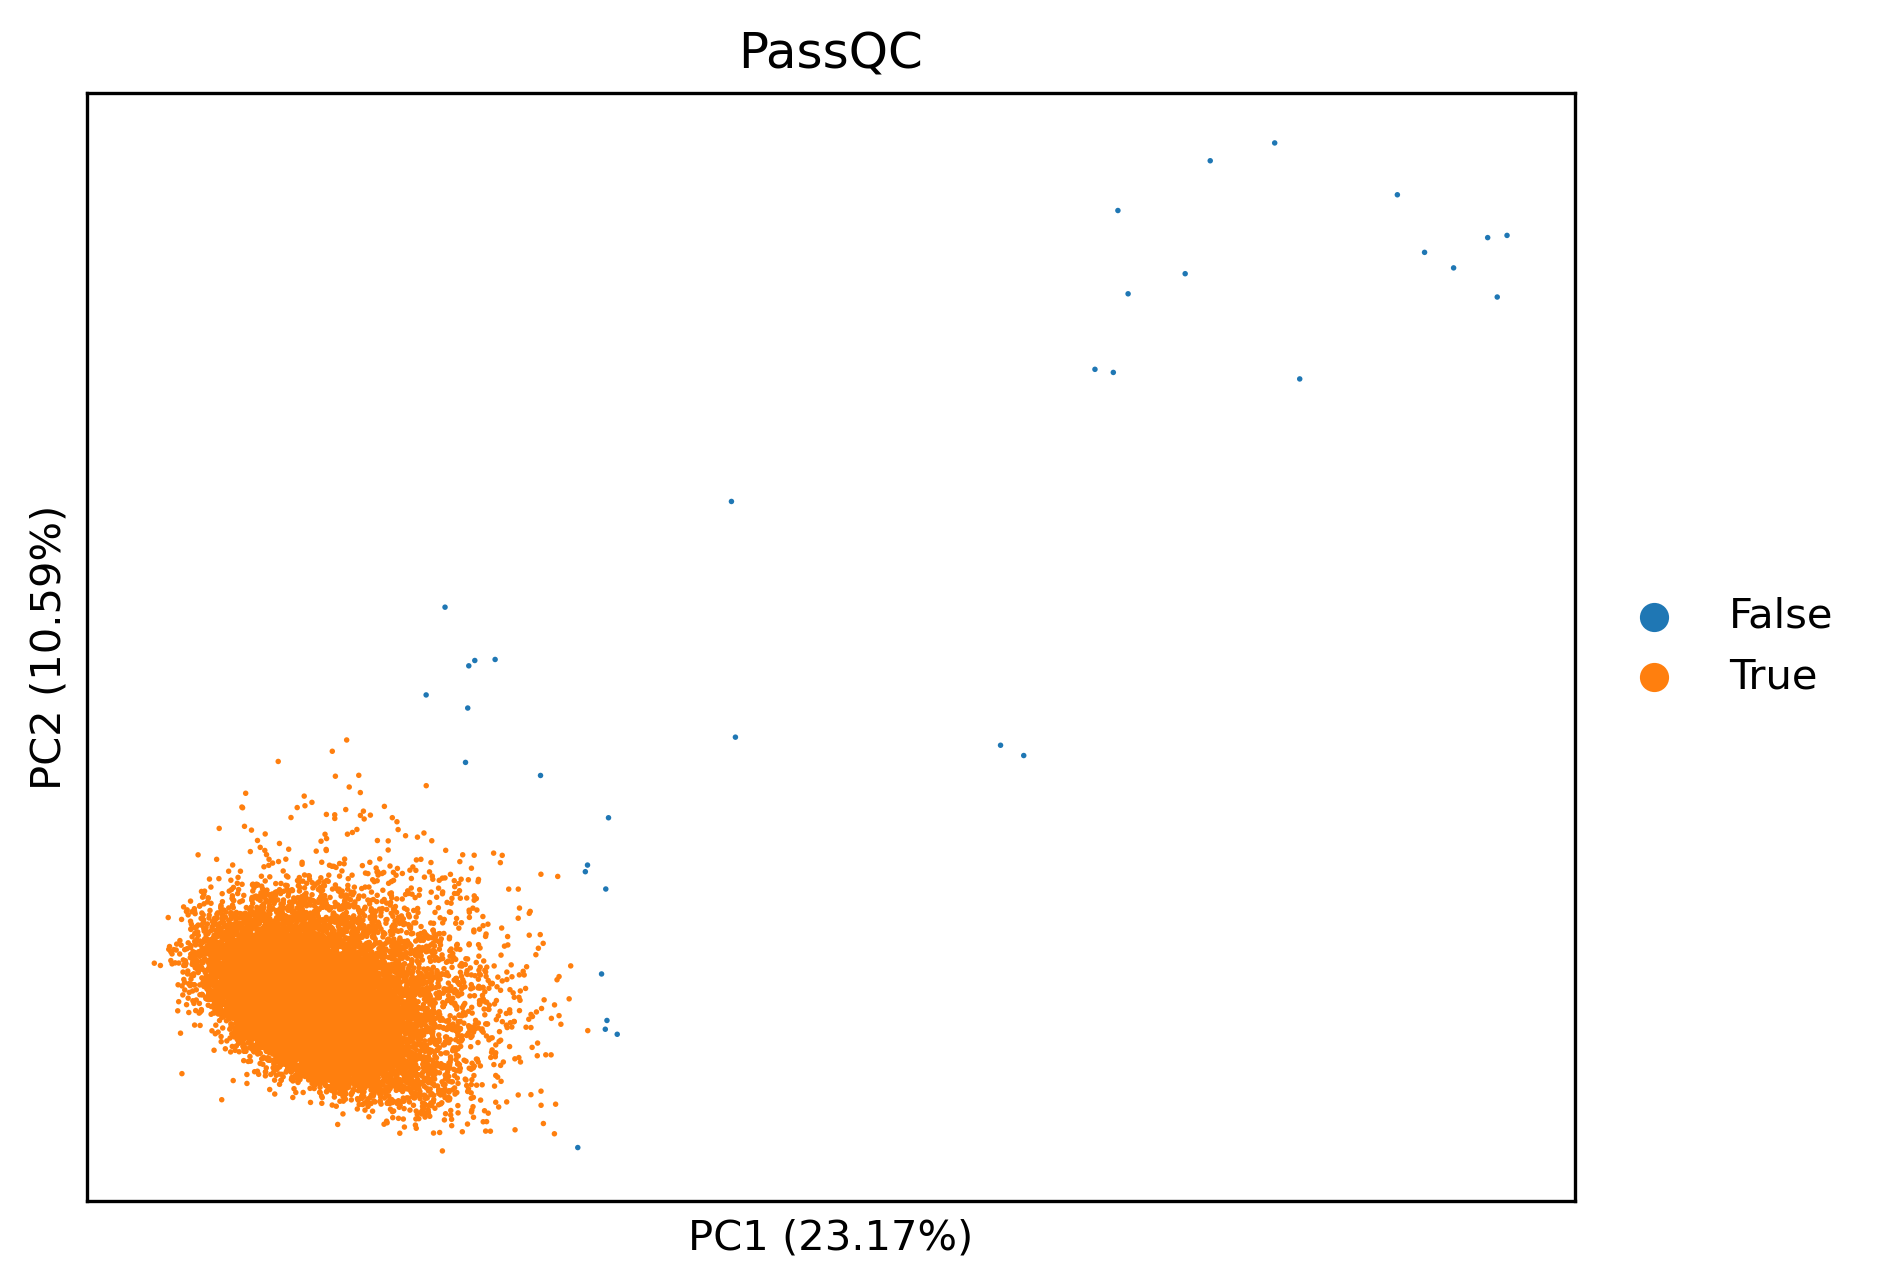

In [14]:
sm.pl.pca(qcadata, color="PassQC")

Now that we know these images may be of low quality, we may also wish to filter
our single-cell data accordingly. In fact, the last time we ran the
`sm.qc.qc_images_by_dissimilarity` function, we already did that, by capturing
`scadata`. Let's look at how many cells are removed by this filtering:

In [15]:
scadata.obs["PassQC"].value_counts()

PassQC
True     12352
False        0
Name: count, dtype: int64

You can see that here no single-cell data was removed. This is because the
single-cell data loaded here only contains cells from a subset of images that we
have image-level features for (see above).

Overall, this step allows fast, semi-unsupervised removal of low quality images.
Keep in mind that must visually inspect outliers, and set a reasonable
threshold for your data based on inspection of example images.

## Impact of arguments on results

Still have not had enough of image QC? Great! This section will tell you about
the impact of the arguments of `sm.qc.qc_images_by_dissimilarity`. We can see
which arguments the function accepts by using the help function: 

In [16]:
help(sm.qc.qc_images_by_dissimilarity)

Help on function qc_images_by_dissimilarity in module scmorph.qc.images:

qc_images_by_dissimilarity(adata: anndata._core.anndata.AnnData, qcadata: anndata._core.anndata.AnnData, filter: bool = True, threshold: float = 0.05, **kwargs) -> tuple[anndata._core.anndata.AnnData, anndata._core.anndata.AnnData]
    Perform QC of datasets using unsupervised, kNN-based distance filtering
    
    Parameters
    ----------
    adata
        Single-cell data
    qcadata
        Image-level data
    filter
        Whether to return filtered or unfiltered (i.e. only annotated) adatas
    threshold
        Threshold for removal
    **kwargs
        Arguments passed to `unsupervised_imageQC`
    
    Returns
    -------
    Tuple of single-cell and image-level adatas



So we see that the main argument for us to vary is the filtering threshold.
However, if we wish for more control over the filtering process, we have to look
at the function that is used underneath, `sm.qc.images.unsupervised_imageQC`,
which in turn uses `kNN_dists`. Lets look at the help function of the latter:

In [17]:
help(sm.qc.images.kNN_dists)

Help on function kNN_dists in module scmorph.qc.images:

kNN_dists(adata: anndata._core.anndata.AnnData, pcs: int = 3, neighbors: int = 10)
    Compute maximum kNN distance (i.e. radius of smallest enclosing circle of kNNs)
    
    Parameters
    ----------
    adata
        image-level data
    pcs
        Number of PCs to use
    neighbors
        Number of image neigbors in PC
    
    Returns
    -------
    For each image, how far is the k-th nearest neighbor away in PC space (measured as Euclidean distance)



Aha! So the filtering is based on two hyperparameters: number of PCs and number
of neighbors considered. To explain a bit more, the number of PCs is the space
in which the distance to other images is computed. The `neighbors` argument on
the other hand determines to which neighbor to determine the distance to. By
default these settings are `3` and `10`, respectively. Does varying them change
the outcome? This is going to require a bit of code now. Feel free to skip ahead
to the figure and the text below it, but of course if you fancy understanding
how this works, by all means do go through it step by step.

In [18]:
# Range of hyperparameters to test
range_pcs = range(2, 16)
range_neighbours = range(1, 16, 1)
results = []

# Test each one individually
for n_pc in tqdm(range_pcs):
    for n_neigh in range_neighbours:
        dists = sm.qc.images.kNN_dists(qcadata, pcs=n_pc, neighbors=n_neigh)
        # Count how many images pass at various thresholds
        percent_passing = (
            np.mean(dists < 0.5),
            np.mean(dists < 0.8),
            np.mean(dists < 1),
        )
        results.append([n_pc, n_neigh, *percent_passing])

  0%|          | 0/14 [00:00<?, ?it/s]

In [19]:
# Collate the results from the loop above into a dataframe, and reshape it to plot with plotnine below
res_df = pd.DataFrame(
    results,
    columns=[
        "pcs",
        "neighbors",
        "pass_0.5",
        "pass_0.8",
        "pass_1.0",
    ],
)
res_df_long = res_df.melt(
    id_vars=["pcs", "neighbors"],
    value_vars=["pass_0.5", "pass_0.8", "pass_1.0"],
    value_name="perc_pass",
    var_name="threshold",
)
res_df_long["perc_pass"] *= 100

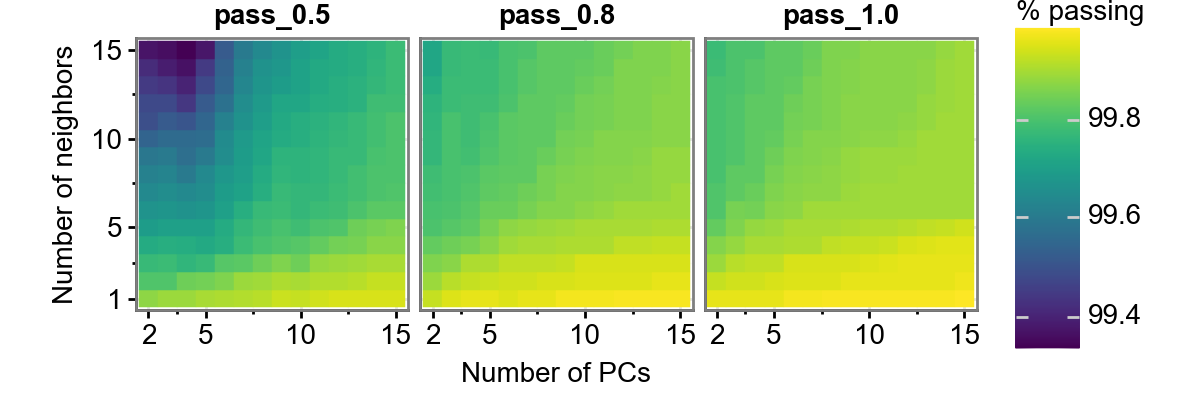

In [20]:
(
    ggplot(
        res_df_long, aes(x="pcs", y="neighbors", color="perc_pass", fill="perc_pass")
    )
    + geom_tile()
    + labs(
        x="Number of PCs", y="Number of neighbors", color="% passing", fill="% passing"
    )
    + theme_bw()
    + facet_wrap("~threshold")
    + scale_x_continuous(expand=(0.01, 0.01), breaks=(2, 5, 10, 15, 20, 25))
    + scale_y_continuous(expand=(0.01, 0.01), breaks=(1, 5, 10, 15, 20, 25))
    + theme(
        text=element_text(color="black", family="Arial", size=10),
        axis_text=element_text(),
        axis_title_y=element_text(angle=90),
        axis_line=element_line(color="black"),
        axis_title=element_text(),
        axis_ticks=element_line(color="black"),
        figure_size=(6, 2),
        aspect_ratio=1,
        strip_background=element_blank(),
        strip_text=element_text(weight="bold"),
    )
)

This figure shows us three thresholds: 0.5, 0.8, and 1.0. Additionally, it
varies the number of neigbors and the number of PCs considered. We can see this,
for this dataset, the number of neighbors has a bigger impact than the number of
PCs considered. Additionally, the percentage of images passing QC does not vary
too dramatically (approximately 99.4-99.8%), so we should be reasonably safe to
use a number of settings. Again, make sure you agree with the images that were
removed, this is just an automated way of flagging potentially low quality images.